# CSCIUA 473 Introduction to Machine Learning Capstone Project
Laurel Xiang

In [2]:
import random
random.seed(15765309)

In [3]:
#navigating to properfile 
import os
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/genre_classification' #MODIFY THIS PATH FOR YOUR OWN DEVICE
os.chdir(path)
os.path.abspath(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/genre_classification'

## Data Processing

Removing null rows, cleaning the data by imputing missing data with the median, normalizing and encoding variables

Lots of libraries to download!

In [83]:
# Numerical/scientific computing packages.
import numpy as np
import scipy
from scipy import stats

# Machine learning package.
import sklearn

#data manipulation
import pandas as pd

#file navigation
import os

# For computing gradients.
import autograd.numpy as np
from autograd import grad

# Useful for saving our models.
import pickle

# Plotting packages.
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn import metrics, model_selection, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster import vq # Specifically uesful for K-means clustering
from sklearn import cluster  # Clustering algorithms such as K-means and agglomerative

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans 
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import MDS #Import the multidimensional scaling module
from scipy.spatial.distance import squareform #Import squareform, which creates a symmetric matrix from a vector
import time
import math
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.stats import multivariate_normal as normal # Multivariate Gaussian distributions
from sklearn import mixture  # Mixture models such as Gaussian Mixture Models
import scipy.cluster.hierarchy as sch
%matplotlib inline
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import pairwise_distances

Importing the dataset

In [5]:
#importing dataset
file = open("musicData.csv","r",encoding="UTF-8")
df = pd.read_csv(file,header=0,index_col=False)
file.close()

In [6]:
vars = list(df.columns)

Obtaining a general idea of where the null or missing values might be

In [7]:
#frequency table of NaN
freqlist = []
dfsubset = df
varnamescompletetemp = list(dfsubset.columns)
for var in varnamescompletetemp:
  temp = [df[var].value_counts().shape[0], dfsubset.shape[0] - dfsubset[var].value_counts().sum(),dfsubset.shape[0],df[var].dtype]
  freqlist.append(temp)
freqtable = pd.DataFrame(freqlist,index=varnamescompletetemp,columns=["# Unique Values","# of NaN","Total","dtype"])
# freqtable.to_csv("nullvaluefreqtable.csv")
freqtable

,# Unique Values,# of NaN,Total,dtype
instance_id,50000,5,50005,float64
artist_name,6863,5,50005,object
track_name,41699,5,50005,object
popularity,99,5,50005,float64
acousticness,4193,5,50005,float64
danceability,1088,5,50005,float64
duration_ms,26028,5,50005,float64
energy,2085,5,50005,float64
instrumentalness,5131,5,50005,float64
key,12,5,50005,object


Realizing that the 5 null values in each variable correspond to a total of 5 rows completely missing of data, and dropping these 5 rows from the dataset

In [8]:
df.dropna(inplace=True) #removes 5 nan values

Using methods such as describe(), info() and value_counts(), I went through each variable and (1) obtained information about its nature, (2) how was missing data was labeled, (3) how to deal with the missing data variable or the variable itself. The information is summarized below.

Variable information<br>
0 - instance_id: unique ids - can drop<br>
1 - artists - filter out for artists with more than n and label the rest as other, empty_field points to nan<br>
2 - track_name: unique strings with frequencies ranging from 1-16<br>
3 - popularity: floats ranging form 0-99, no missing<br>
4 - acousticness: dfloats ranging from 0-1, with value frequencies ranging from 1-278<br>
5 - danceability: floats ranging from 0.05 to 0.98<br>
6 - duration_ms: floats ranging from 1.55*10^4 to 4.83*10^6 4939 values with -1<br>
7 - energy: floats ranging from 0 to 1 <br>
8 - instrumentalness: floats ranging from 0 to 1, 15001 values as 0 -> abnormal<br>
9 - key: 12 unique values A-G, not regular distribution (see bar graph)<br>
10 - liveness: floats between 0 to 1<br>
11 - loudness: floats between -48 and 4<br>
12 - mode: binary (major or minor) with 2:1 ratio<br>
13 - speechiness: floats between 0 to 1<br>
14 - tempo: floats between 34 and 221, 4980 values as ?, must convert from object to float<br>
15 - obtained_date: 4 dates between 4/1 to 4/4, with 1 value marked as 0/4<br>
16 - valence: floats between 0 and 1, 2 values as 0 but maybe that's normal since there are only 2<br>
17 - music_genre: 10 genres, 5000 values each<br>

In [9]:
# how variable information was obtained
# df[vars[2]].describe()
# pd.to_numeric(df[vars[16]].loc[df[vars[16]] == 0]).describe()
# df[vars[2]].value_counts()
# df[vars[14]].loc[df[vars[14]] == 0].value_counts()
# df.info()

A few functions to help with the data imputation

In [10]:
#data processing functions
def getAggregateMedian(var0,var1,df,toreplace):
    """
    This function calculates the median of var0 when grouped by var1 (aggregate median), 
    with the values in toreplace filtered out in dataframe df.
    To be applied to dataframe.
    @params
    df: dataframe
    var0: numerical variable to get aggregate median
    var1: variable to aggregate by
    toreplace: list of variables to replace by, assumes numerical
    @returns
    meddict: dictionary of values in var0 as keys and aggregate medians as values
    """
    arr = list(df[var1].value_counts().index)
    arrmed = []
    for g in arr:
        for val in toreplace:
            df = df.loc[df[var0] != val]
        med = np.median(df.loc[df[var1] == g,var0])
        arrmed.append(med)
    meddict = dict(zip(arr,arrmed))
    return meddict
def transformToMedian(x,var0, var1,sett,value,cols):
    """
    This function imputes the aggregated median value of var0 by var1
    To be applied to dataframe
    @params
    x: numpy array and changes x based on its var value on set
    sett: dictionary contianing var with associated median value
    var0: name of variable to impute
    var1: name of variable to filter data
    value: list of values to impute
    cols: list of column names to get index of var0 and var1, 
      assumes order of cols is also the order of cols in x
    @returns
    x: ndarray with potential imputation
    """
    for v in range(len(cols)): #getting var name
      if var0 == cols[v]:
        var0=v
    for v in range(len(cols)): #getting var name
      if var1 == cols[v]:
        var1=v
    boolean = False
    for v in value:
      if x[var0] == v:
        boolean = True
    if boolean: #only change value if it is a certain value
        x[var0] = sett[x[var1]]
    return x
def transformToOther(x,sett):
    """
    This function groups rare values together and replaces them with one new value called Other
    To be applied to dataframe
    @params
    x: value
    sett: set of values that will be converted to Other
    @returns
    x or "Other": new or old value
    """
    if x not in sett:
        return "Other"
    return x

### Processing key
Converting keys into dummy variables

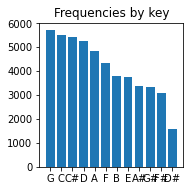

In [11]:
#distribution of frequencies of notes
fig = plt.figure(figsize=(2,2))
ax = fig.add_axes([0,0,1,1])
langs = list(df[vars[9]].value_counts().index)
vals = df[vars[9]].value_counts()
ax.bar(langs,vals)
plt.title("Frequencies by key")
plt.show()

### Processing artist_name
Converting artists with low number of tracks to Other and retaining artists with high number of tracks

In [12]:
artistvalcount = pd.DataFrame(df[vars[1]].value_counts(),columns=["artist_name"])
# avc = artistvalcount.loc[artistvalcount["artist_name"] > 10]
avc = artistvalcount.drop(labels=["empty_field"],axis=0)

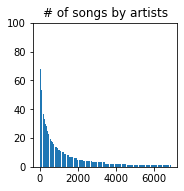

In [13]:
#zipf's law applying here
fig = plt.figure(figsize=(2,2))
ax = fig.add_axes([0,0,1,1])
# langs = list(artistvalcount.index)
langs = []
for i in range(avc.shape[0]):
    langs.append(i)
vals = list(avc["artist_name"])
ax.bar(langs,vals)
plt.ylim((0,100))
plt.title("# of songs by artists")
plt.show()

In [14]:
print("# of artists:",avc.loc[avc["artist_name"] > 150].shape) #filtering 26 most popular artists - this parameter can be tuned
mostfreqartists = set(avc.loc[avc["artist_name"] > 150].index)

# of artists: (8, 1)


In [15]:
#if not an artist with more than 80 songs, making it other
df["artist_name"] = df["artist_name"].apply(lambda x : transformToOther(x,mostfreqartists))

### Processing duration_ms
Replacing -1 with median of genre duration

In [16]:
#calculating median of genre duration
genres = getAggregateMedian("duration_ms","music_genre",df,[-1])
#applying median to duration_ms with -1
df = df.apply(lambda x : transformToMedian(x,"duration_ms","music_genre",genres,[-1],list(df.columns)),raw=True,axis=1, result_type='broadcast')

### Processing by instrumentalness
Replacing 0 with median of genre duration

In [17]:
#calculating median of genre duration
genres = getAggregateMedian("instrumentalness","music_genre",df,[0])
#applying median to duration_ms with -1
df = df.apply(lambda x : transformToMedian(x,"instrumentalness","music_genre",genres,[0],list(df.columns)),raw=True,axis=1)

### Processing by mode
Encoding major with 0 and minor with 1

In [18]:
df.loc[df["mode"] == "Major", "mode"] = 0
df.loc[df["mode"] == "Minor", "mode"] = 1

### Processing by tempo
Replacing ? with median of genre duration

In [19]:
df["tempo"] = df["tempo"].replace(to_replace=["?"],value=[-1])
df["tempo"] = pd.to_numeric(df["tempo"])
#calculating median of genre tempo
genres = getAggregateMedian("tempo","music_genre",df,[-1])
#applying median to tempo with ?
df = df.apply(lambda x : transformToMedian(x,"tempo","music_genre",genres,[-1],list(df.columns)),raw=True,axis=1)

### Processing instance_id, track_name and obtained_date
removing since ID is unique <br>
track name is almost unique (too unique to add info)<br>
obtained date is not relevant <br>

In [20]:
#dropping instance_id and track_name
df = df.drop(columns=["instance_id","track_name","obtained_date"])
freqtable = freqtable.drop(index=["instance_id","track_name","obtained_date"])

### Encoding
Transforming key and artist name to dummy variables<br>
Encode music genre

In [21]:
df = pd.get_dummies(df,columns=["key","artist_name"],dtype='float')
df = df.drop(columns=["artist_name_Other"])

In [22]:
indexes = []
for i in range(10):
    indexes.append(i)
genre = dict(zip(list(df["music_genre"].value_counts().index),indexes))

In [23]:
def encode(x,set):
    return set[x]
df["music_genre"] = df["music_genre"].apply(lambda x : encode(x,genre))

In [24]:
len(list(df.columns))

33

##Splitting the dataset for testing and training
All the data processing steps unaffected by dataset splitting has been done. The dataset must now be split into test and train sets, as well as by genre, because the rest of the preprocessing steps require these splits.<br>

In [25]:
#sort by genre
genre_type = df["music_genre"].value_counts().index.tolist()

X_train = pd.DataFrame([]*df.shape[1],columns=list(df.columns))
X_test = pd.DataFrame([]*df.shape[1],columns=list(df.columns))

#splitting test and train test by aggregated genre and adding them to the big test and train set
for i in range(len(genre_type)):
  X_train_temp, X_test_temp = train_test_split(df.loc[df["music_genre"] == genre_type[i]],test_size=0.10,random_state=15765309)
  X_train = pd.concat([X_train,X_train_temp],axis=0)
  X_test = pd.concat([X_test,X_test_temp],axis=0)

### Standardization of train and test sets

Applied to train and test set separately

In [26]:
tonstandardize = freqtable[freqtable["dtype"] == "float64"].index.tolist()
tonstandardize.append("tempo")
print("variables that will be standardized:",tonstandardize)

variables that will be standardized: ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']


In [27]:
for var in tonstandardize:
    sc = StandardScaler()
    X_train[var] = sc.fit_transform(np.array(X_train[var]).reshape(-1,1))
    X_test[var] = sc.fit_transform(np.array(X_test[var]).reshape(-1,1))

Ensuring dtype is numerical

In [28]:
tonstandardize.append("mode")
for var in tonstandardize:
  X_train[var] = pd.to_numeric(X_train[var])
  X_test[var] = pd.to_numeric(X_test[var])

Dropping the genre label for clustering

In [29]:
X_train_genre_ = pd.to_numeric(X_train["music_genre"].copy(deep=True))
X_train_ = X_train.drop(columns=["music_genre"]).copy(deep=True)
X_test_genre_ = pd.to_numeric(X_test["music_genre"].copy(deep=True))
X_test_ = X_test.drop(columns=["music_genre"]).copy(deep=True)

In [30]:
# X_train_genre_ = pd.get_dummies(X_train_genre_,columns=["music_genre"])
# X_test_genre_ = pd.get_dummies(X_test_genre_,columns=["music_genre"])

In [31]:
X_train_genre = pd.to_numeric(X_train["music_genre"].copy(deep=True))
X_train = X_train.drop(columns=["music_genre"])
X_test_genre = pd.to_numeric(X_test["music_genre"].copy(deep=True))
X_test = X_test.drop(columns=["music_genre"])

## Dimensionality Reduction
Testing PCA, t-SNE, and MDS methods to cluster

### PCA

Full PCA on X_train

In [32]:
# pca = PCA(n_components=2, whiten=True)
pca = PCA(whiten=True)
Xpca = pca.fit_transform(X_train)

In [33]:
eig_vals = pca.explained_variance_
loadings = pca.components_
covar_explained = eig_vals/sum(eig_vals)*100

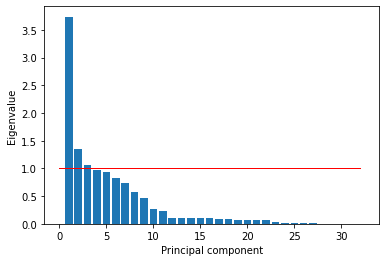

In [34]:
num_classes = X_train.shape[1]
plt.bar(np.linspace(1,num_classes,num_classes),eig_vals)
# plt.plot(eig_vals)
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.plot([0,num_classes],[1,1],color='red',linewidth=1) # Kaiser criterion line

2-component PCA on X_train

In [35]:
pca = PCA(n_components=2,whiten=True)
Xpca_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.3066695 , 0.11068449])

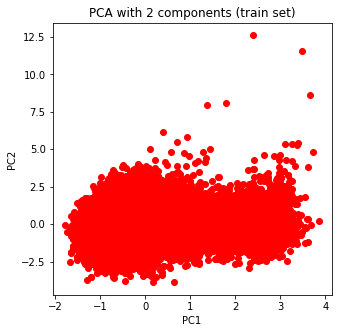

In [36]:
plt.figure(figsize=(5, 5))
plt.scatter(Xpca_train[:,0], Xpca_train[:, 1],c='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA with 2 components (train set)")
plt.show()

### t-SNE

In [37]:
# tsne_train = TSNE(n_components=2)
# tsne_train.fit(X_train)

In [38]:
# plt.figure(figsize=(5, 5))
# plt.scatter(tsne_train.embedding_[:,0], tsne_train.embedding_[:, 1],c='r')
# plt.xlabel('tsne1')
# plt.ylabel('tsne2')
# plt.title("tsne (train set) with 2 components, perplexity 30")
# plt.show()

In [39]:
# tsne_test = TSNE(n_components=2)
# tsne_test.fit(X_test)

In [40]:
# plt.figure(figsize=(5, 5))
# plt.scatter(tsne_test.embedding_[:,0], tsne_test.embedding_[:, 1],c='r')
# plt.xlabel('tsne1')
# plt.ylabel('tsne2')
# plt.title("tsne (test set) with 2 components, perplexity 30")
# plt.show()

### MDS

In [41]:
# D = pairwise_distances(X)
# mds = MDS(n_components=2, n_init=100, max_iter = 10000, dissimilarity='precomputed') #Create the mds object
# #Components: Looking for a 2D solution, n_init: Number of runs with random initial starting positions, max_iter: Max number of iterations per run, dissimilarity: We already did it, from out distance matrix, 
# mdsSolution = mds.fit_transform(D) #Actually run the mds

In [42]:
# plt.scatter(mdsSolution[:,0], mdsSolution[:,1], color='blue') #Making the plot, first 2 dimensions
# for ii in range(len(mdsSolution)):
#     plt.text(mdsSolution[ii,0], mdsSolution[ii,1],"")

# plt.xlabel('MDS axis 1')
# plt.ylabel('MDS axis 2')
# plt.show()

# print(mds.stress_) #How low could we get the stress? [Un-normalized]

In [43]:
# stress = np.sqrt(mds.stress_ / (0.5 * np.sum(df.values ** 2)))
# print(stress)

## Clustering
10 clusters (10 music genres) applied on PCA. t-SNE results in too much data leackage and MDS is too computationally complex (made my computer and google colab crash).

### K-Means based on PCA

For n_clusters = 10 The average silhouette_score is : 0.3309975490943133


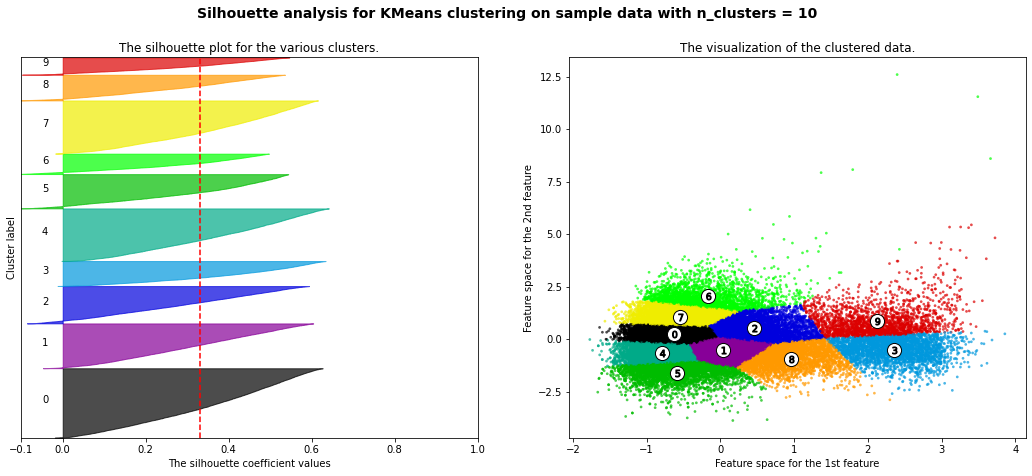

In [44]:
X = Xpca_train

n_clusters = 10

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

## Prediction Model
Predicting and adding the clustering labels to the test set <br>
Testing Logistic Regression, SVM, AdaBoost

In [45]:
X_train_labels = clusterer.labels_
X_train["clustered_music_genre"] = X_train_labels
X_test_labels = clusterer.predict(pca.fit_transform(X_test))
X_test["clustered_music_genre"] = X_test_labels

### Preparing data for prediction modelling

Test Train names: <br>
X_train: Predictor training set (45000 datapoints)<br>
X_train_genre: Outcome training set (5000 datapoints)<br>
X_test: Predictor test set (45000 datapoints)<br>
X_test_genre Outcome test set (5000 datapoints)

In [48]:
X_train = pd.get_dummies(X_train,columns=["clustered_music_genre"])
X_test = pd.get_dummies(X_test,columns=["clustered_music_genre"])

In [49]:
X_train_genre = pd.get_dummies(X_train_genre,columns=["music_genre"])
X_test_genre = pd.get_dummies(X_test_genre,columns=["music_genre"])

X_train_genre_ = pd.get_dummies(X_train_genre_,columns=["music_genre"])
X_test_genre_ = pd.get_dummies(X_test_genre_,columns=["music_genre"])

### Logistic Regression

In [50]:
plot = []
for i in range(10):
  model = LogisticRegression(max_iter=5000)
  model.fit(X_train, X_train_genre[i])
  logreg_pred = model.predict_proba(X_test)[:,1]
  logit_roc_auc = roc_auc_score(X_test_genre[i], logreg_pred)
  fpr, tpr, thresholds = roc_curve(X_test_genre[i], logreg_pred)
  accu = metrics.accuracy_score(X_test_genre[i], np.around(logreg_pred))
  # print(pd.DataFrame(np.array([np.around(logreg_pred),X_test_genre_[i]]).transpose(),columns=["pred","act"]).value_counts())
  plot.append([logit_roc_auc,fpr,tpr,accu])

In [58]:
genrerev = dict(zip(list(genre.values()),list(genre.keys())))

accuracy of Electronic is 0.9166
accuracy of Anime is 0.94
accuracy of Jazz is 0.9054
accuracy of Alternative is 0.9
accuracy of Country is 0.9
accuracy of Rap is 0.901
accuracy of Blues is 0.9064
accuracy of Rock is 0.9076
accuracy of Classical is 0.9662
accuracy of Hip-Hop is 0.8956


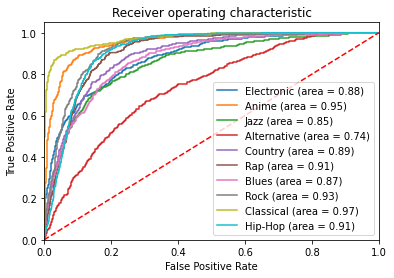

In [66]:
plt.figure()
for i in range(10):
  plt.plot(plot[i][1], plot[i][2], label=genrerev[i]+' (area = %0.2f)' % plot[i][0])
  print("accuracy of",genrerev[i],"is",plot[i][3])
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [64]:
avgauc = []
avgacc = []
for i in range(10):
  avgauc.append(plot[i][0])
  avgacc.append(plot[i][3])

In [65]:
print("average auc score:",np.mean(avgauc))
print("average accuracy score:",np.mean(avgacc))

average auc score: 0.8903294666666668
average accuracy score: 0.91388


### Logistic Regression on dataset without clustering labels

In [67]:
plot = []
for i in range(10):
  model = LogisticRegression(max_iter=5000)
  model.fit(X_train_, X_train_genre_[i])
  logreg_pred_ = model.predict_proba(X_test_)[:,1]
  logit_roc_auc = roc_auc_score(X_test_genre_[i], logreg_pred_)
  fpr, tpr, thresholds = roc_curve(X_test_genre_[i], logreg_pred_)
  accu = metrics.accuracy_score(X_test_genre_[i], np.around(logreg_pred_))
  # print(pd.DataFrame(np.array([np.around(logreg_pred_),X_test_genre_[i]]).transpose(),columns=["pred","act"]).value_counts())
  plot.append([logit_roc_auc,fpr,tpr,accu])

accuracy of 0 is 0.9148
accuracy of 1 is 0.9382
accuracy of 2 is 0.9014
accuracy of 3 is 0.8998
accuracy of 4 is 0.8998
accuracy of 5 is 0.9014
accuracy of 6 is 0.8998
accuracy of 7 is 0.9086
accuracy of 8 is 0.9666
accuracy of 9 is 0.8962


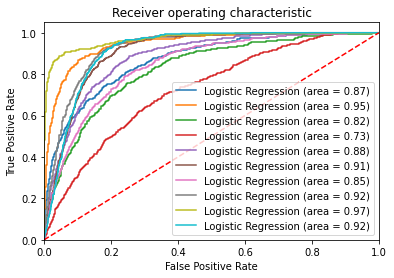

In [68]:
plt.figure()
for i in range(10):
  plt.plot(plot[i][1], plot[i][2], label='Logistic Regression (area = %0.2f)' % plot[i][0])
  print("accuracy of",i,"is",plot[i][3])
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [69]:
avgauc = []
avgacc = []
for i in range(10):
  avgauc.append(plot[i][0])
  avgacc.append(plot[i][3])

In [70]:
print("average auc score:",np.mean(avgauc))
print("average accuracy score:",np.mean(avgacc))

average auc score: 0.8811484888888887
average accuracy score: 0.9126600000000001


### SVM

In [72]:
plot = []
for i in range(10):
  svm = LinearSVC(C = 1e-10, dual = False)
  model = CalibratedClassifierCV(svm)
  model.fit(X_train, X_train_genre[i])
  logreg_pred = model.predict_proba(X_test)[:,1]
  logit_roc_auc = roc_auc_score(X_test_genre[i], logreg_pred)
  fpr, tpr, thresholds = roc_curve(X_test_genre[i], logreg_pred)
  accu = metrics.accuracy_score(X_test_genre[i], np.around(logreg_pred))
  # print(pd.DataFrame(np.array([np.around(logreg_pred),X_test_genre_[i]]).transpose(),columns=["pred","act"]).value_counts())
  plot.append([logit_roc_auc,fpr,tpr,accu])

accuracy of Electronic is 0.9
accuracy of Anime is 0.9024
accuracy of Jazz is 0.9
accuracy of Alternative is 0.9
accuracy of Country is 0.9
accuracy of Rap is 0.9004
accuracy of Blues is 0.9
accuracy of Rock is 0.9
accuracy of Classical is 0.9586
accuracy of Hip-Hop is 0.8996


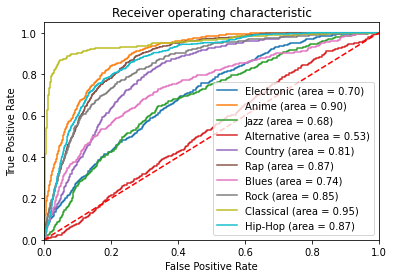

In [73]:
plt.figure()
for i in range(10):
  plt.plot(plot[i][1], plot[i][2], label=genrerev[i]+' (area = %0.2f)' % plot[i][0])
  print("accuracy of",genrerev[i],"is",plot[i][3])
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [74]:
avgauc = []
avgacc = []
for i in range(10):
  avgauc.append(plot[i][0])
  avgacc.append(plot[i][3])

print("average auc score:",np.mean(avgauc))
print("average accuracy score:",np.mean(avgacc))

average auc score: 0.7901547111111111
average accuracy score: 0.9061


### Random Forest

In [78]:
plot = []
for i in range(10):
  model = RandomForestClassifier(criterion='gini')
  model.fit(X_train, X_train_genre[i])
  logreg_pred = model.predict_proba(X_test)[:,1]
  logit_roc_auc = roc_auc_score(X_test_genre[i], logreg_pred)
  fpr, tpr, thresholds = roc_curve(X_test_genre[i], logreg_pred)
  accu = metrics.accuracy_score(X_test_genre[i], np.around(logreg_pred))
  # print(pd.DataFrame(np.array([np.around(logreg_pred),X_test_genre_[i]]).transpose(),columns=["pred","act"]).value_counts())
  plot.append([logit_roc_auc,fpr,tpr,accu])

accuracy of Electronic is 0.9286
accuracy of Anime is 0.9588
accuracy of Jazz is 0.9224
accuracy of Alternative is 0.9002
accuracy of Country is 0.9
accuracy of Rap is 0.8984
accuracy of Blues is 0.9264
accuracy of Rock is 0.9046
accuracy of Classical is 0.9728
accuracy of Hip-Hop is 0.896


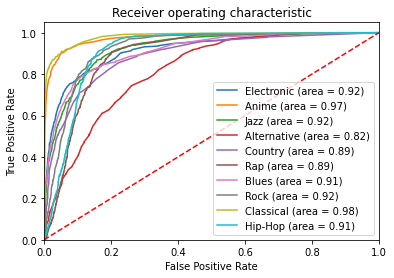

In [79]:
plt.figure()
for i in range(10):
  plt.plot(plot[i][1], plot[i][2], label=genrerev[i]+' (area = %0.2f)' % plot[i][0])
  print("accuracy of",genrerev[i],"is",plot[i][3])
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [80]:
avgauc = []
avgacc = []
for i in range(10):
  avgauc.append(plot[i][0])
  avgacc.append(plot[i][3])

print("average auc score:",np.mean(avgauc))
print("average accuracy score:",np.mean(avgacc))

average auc score: 0.9152376666666667
average accuracy score: 0.92082


### AdaBoost

In [84]:
plot = []
for i in range(10):
  model = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), algorithm = 'SAMME',learning_rate = 1, n_estimators = 100)
  model.fit(X_train, X_train_genre[i])
  logreg_pred = model.predict_proba(X_test)[:,1]
  logit_roc_auc = roc_auc_score(X_test_genre[i], logreg_pred)
  fpr, tpr, thresholds = roc_curve(X_test_genre[i], logreg_pred)
  accu = metrics.accuracy_score(X_test_genre[i], np.around(logreg_pred))
  # print(pd.DataFrame(np.array([np.around(logreg_pred),X_test_genre_[i]]).transpose(),columns=["pred","act"]).value_counts())
  plot.append([logit_roc_auc,fpr,tpr,accu])

accuracy of Electronic is 0.9214
accuracy of Anime is 0.9516
accuracy of Jazz is 0.9118
accuracy of Alternative is 0.8946
accuracy of Country is 0.9
accuracy of Rap is 0.9014
accuracy of Blues is 0.9184
accuracy of Rock is 0.91
accuracy of Classical is 0.9648
accuracy of Hip-Hop is 0.8998


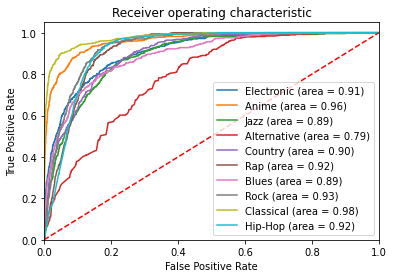

In [85]:
plt.figure()
for i in range(10):
  plt.plot(plot[i][1], plot[i][2], label=genrerev[i]+' (area = %0.2f)' % plot[i][0])
  print("accuracy of",genrerev[i],"is",plot[i][3])
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [86]:
avgauc = []
avgacc = []
for i in range(10):
  avgauc.append(plot[i][0])
  avgacc.append(plot[i][3])

print("average auc score:",np.mean(avgauc))
print("average accuracy score:",np.mean(avgacc))

average auc score: 0.9083663111111111
average accuracy score: 0.9173800000000002
